In [1]:
from numpy import random
from IPython.display import clear_output
import time
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation
from statsmodels.stats.stattools import durbin_watson
from scipy import ndimage

In [2]:
def life_step(X):
    
    """Game of life step using generator expressions"""
    
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

In [3]:
def life_animation(X, dpi=80, frames=10, interval=300, mode='loop'):
    
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(int) 
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)  
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(-0.05, 10)
    
    # initialization function: plot the background of each frame
    
    def init():
        
        im.set_data(X_blank)
        return (im,)
    
    # animation function.  This is called sequentially
    
    def animate(i):
        
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        
        return (im,)
    
    animate.X = X
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=frames,
                                   interval=interval)
    
    return display_animation(anim, default_mode=mode)      

In [4]:
def add_border(x, border = 3):
        
        offset = int((border - 1)/2)
        
        background = np.repeat(0, x.shape[0] *
                               x.shape[1] *
                               border *
                               border).reshape([x.shape[0] *
                                                border, x.shape[1] *
                                                border])
        background[x.shape[0] *
                   offset:-x.shape[0] *
                   offset, x.shape[1] *
                   offset:-x.shape[1] *
                   offset] = x
        
        return(background)

In [5]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]]
[[nan]]



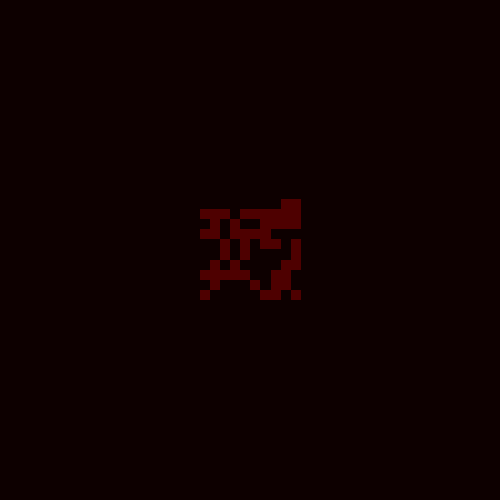
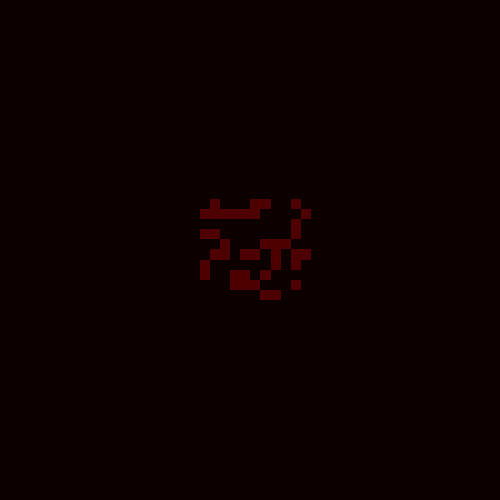
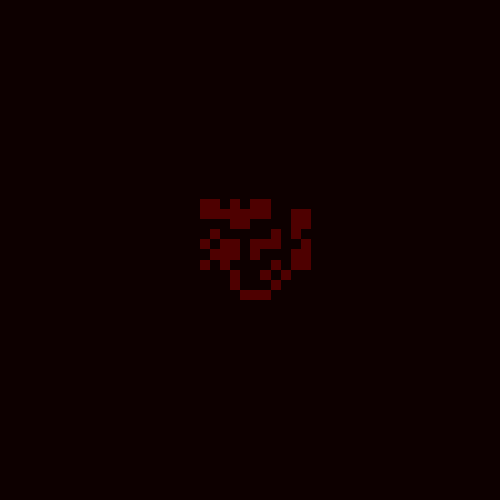
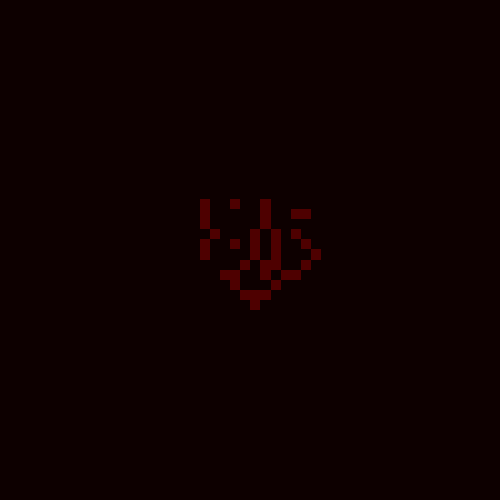
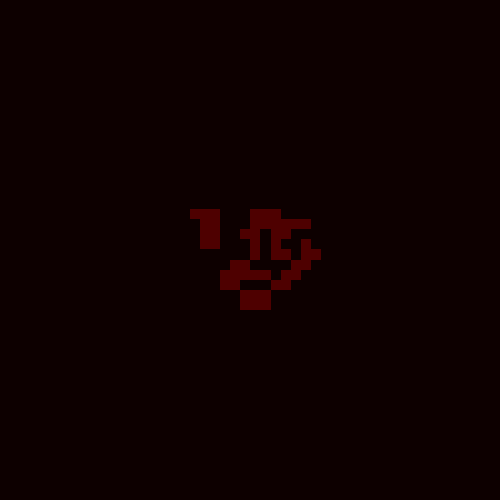
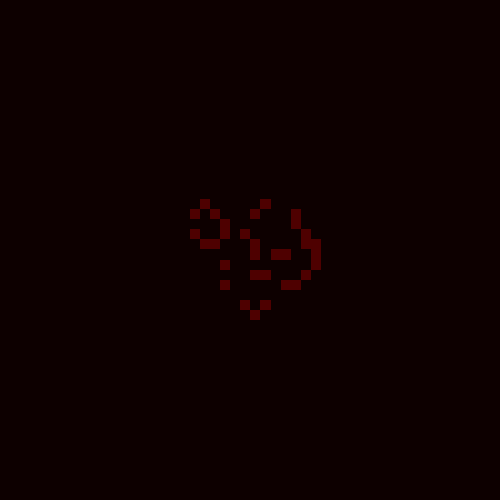
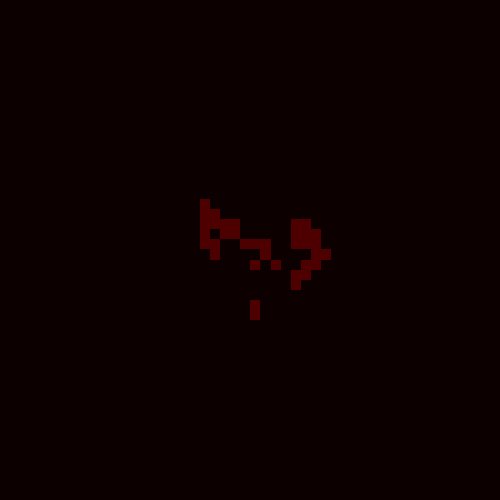
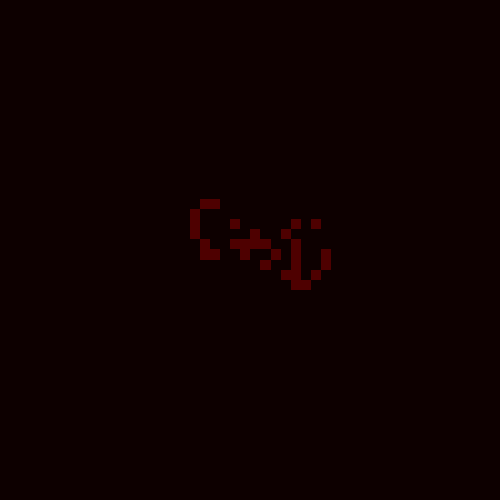
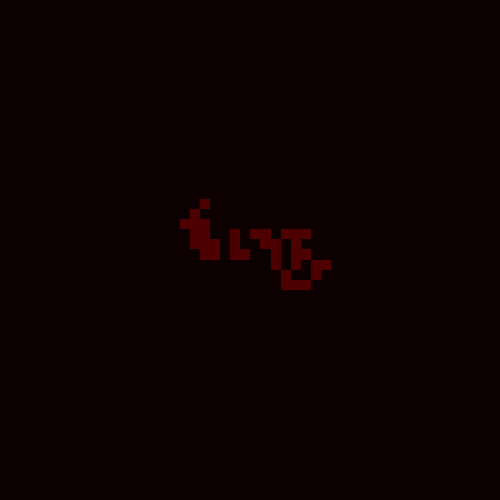
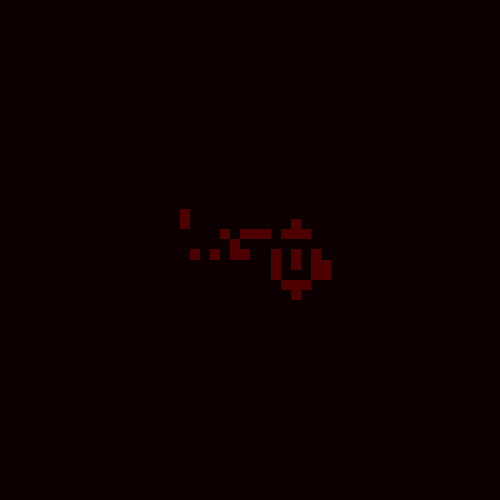
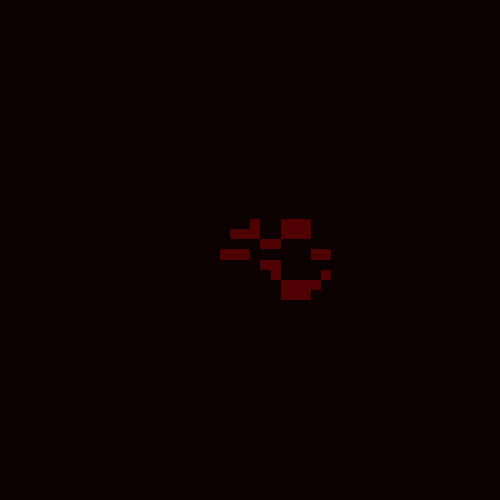
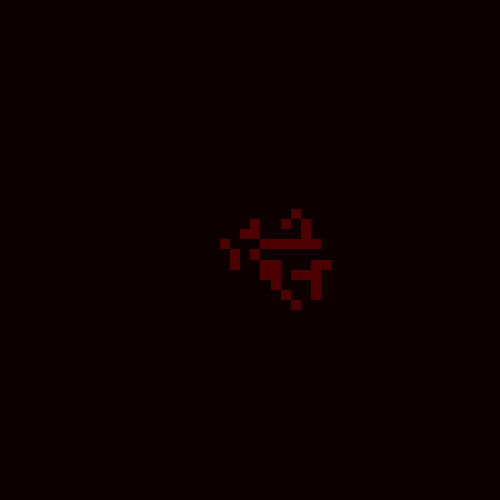
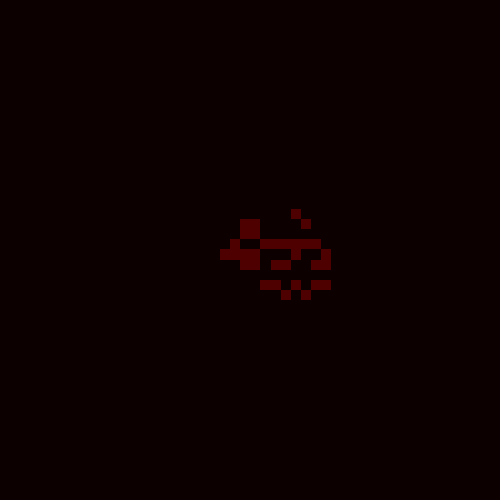
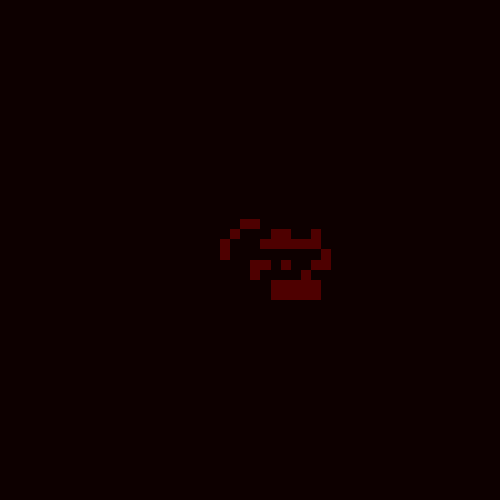
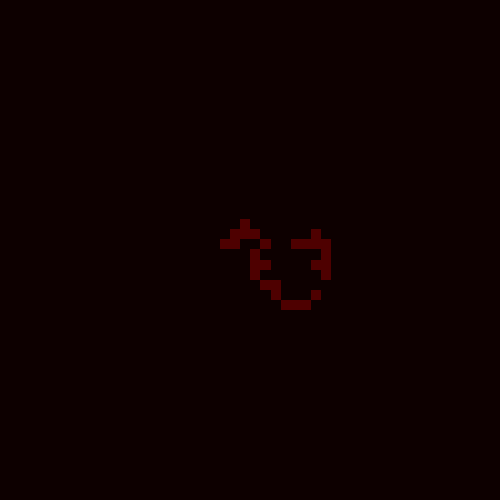
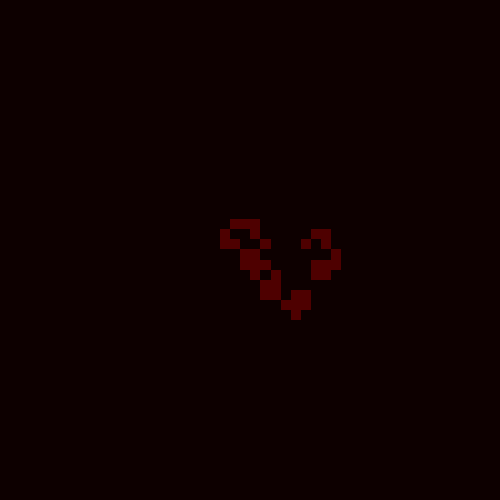
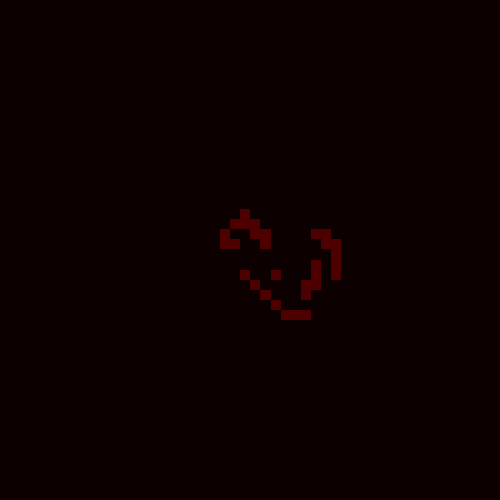
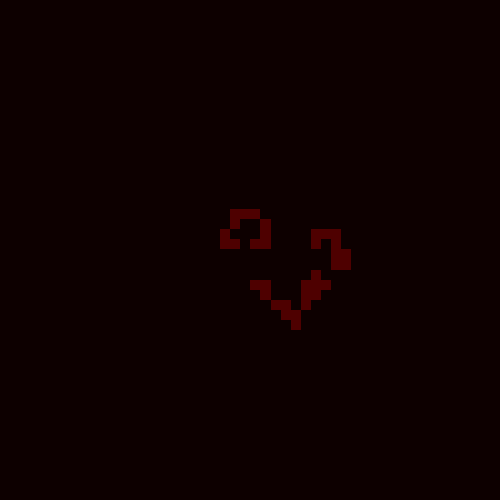
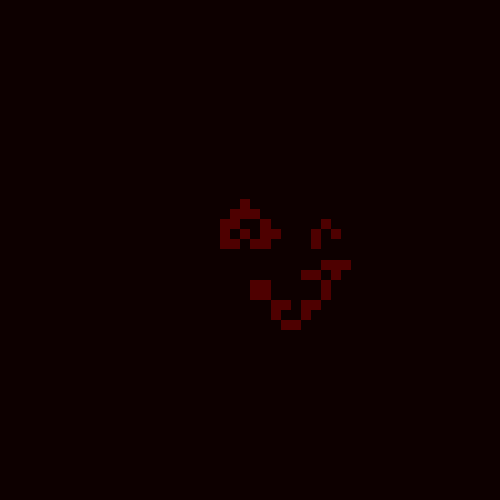
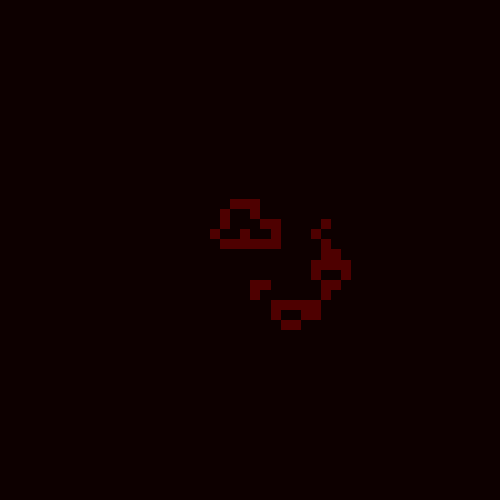
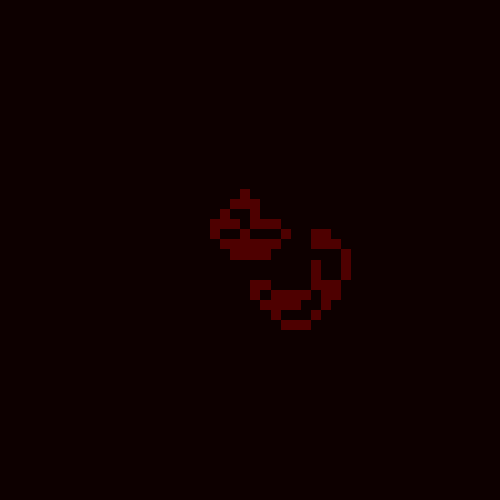
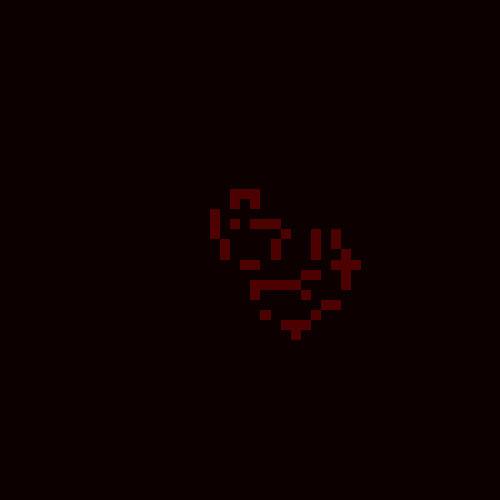
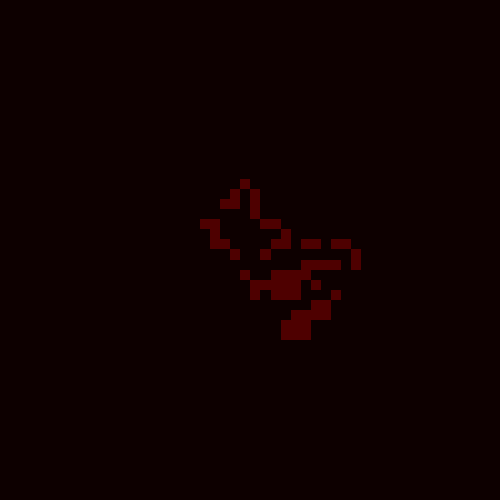
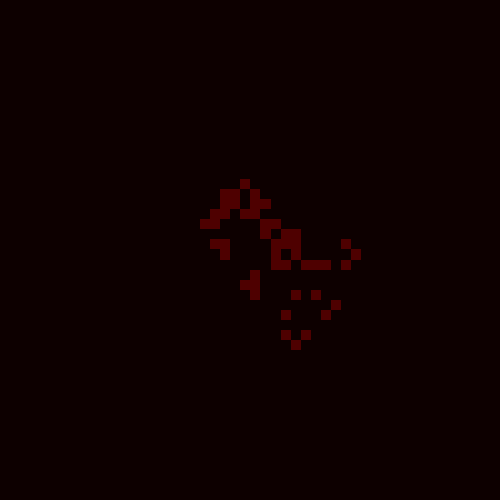
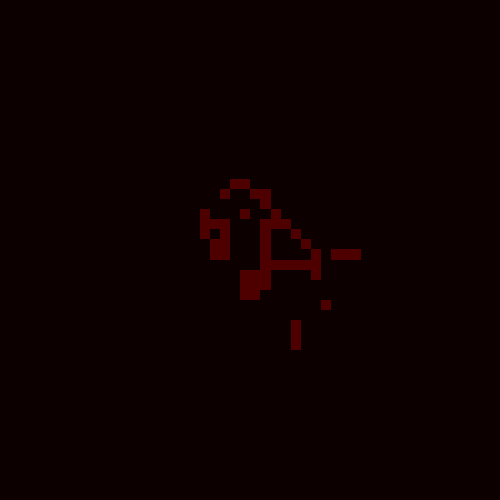
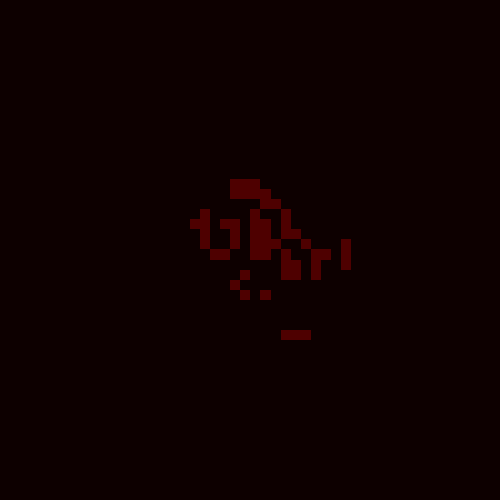
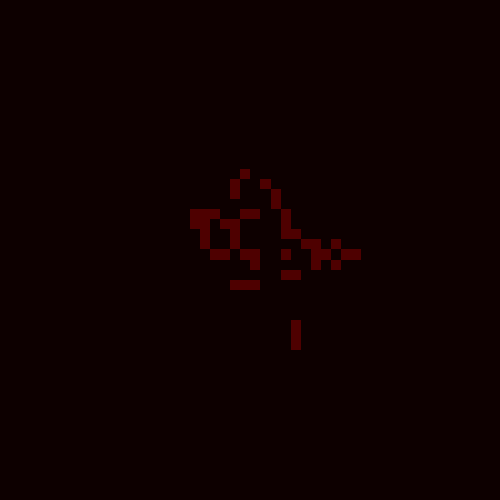
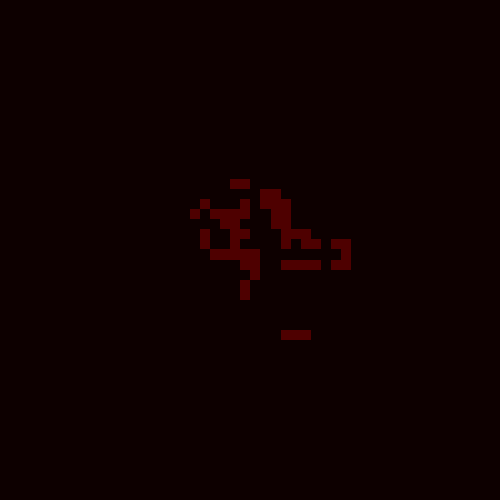
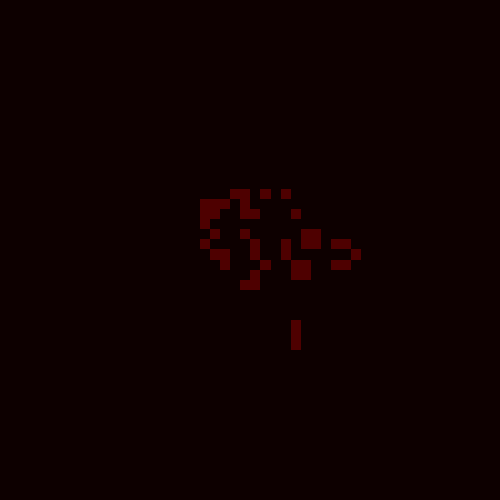
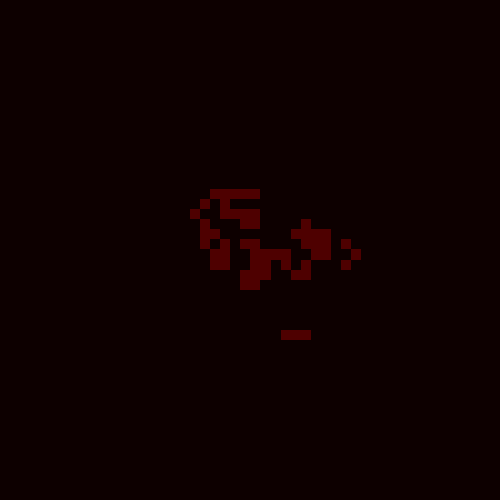
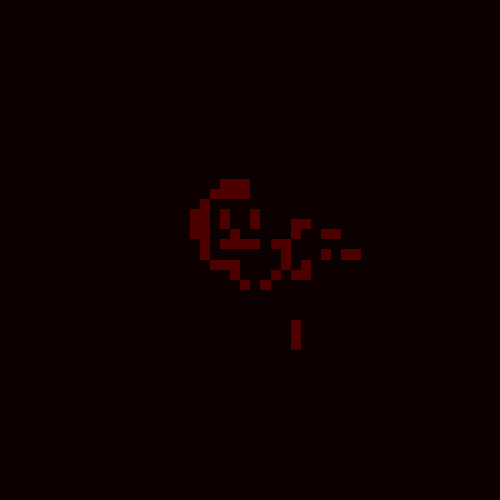
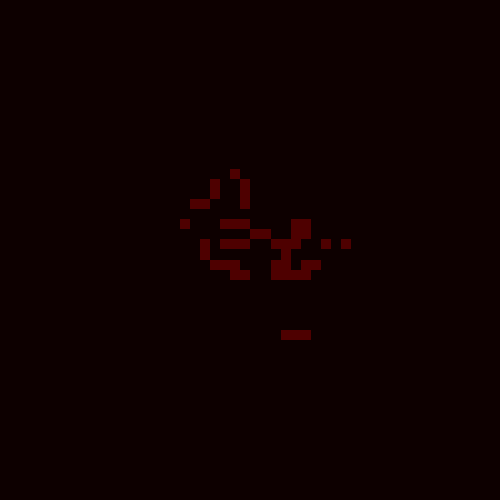
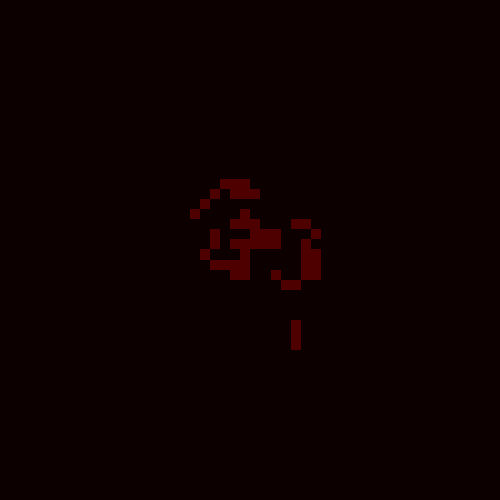
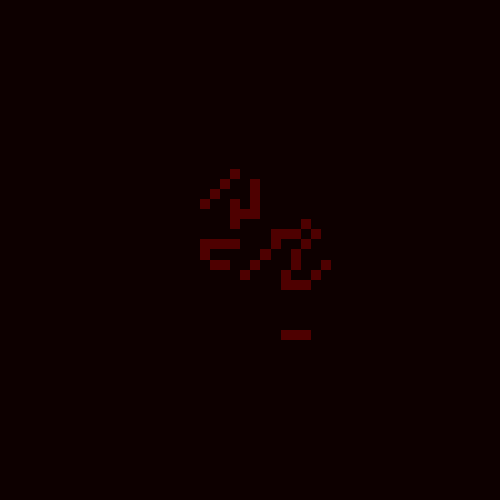
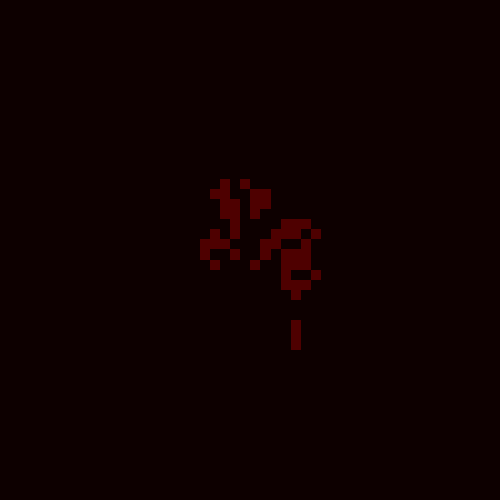
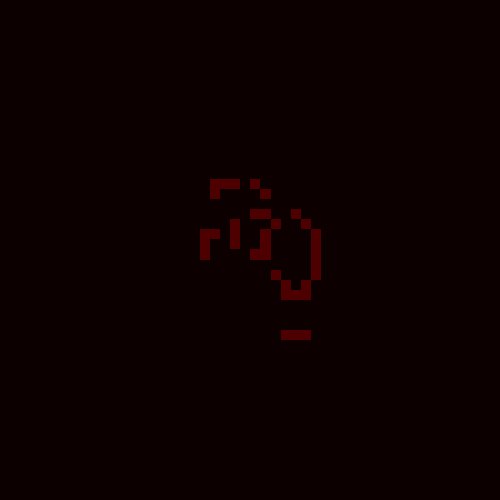
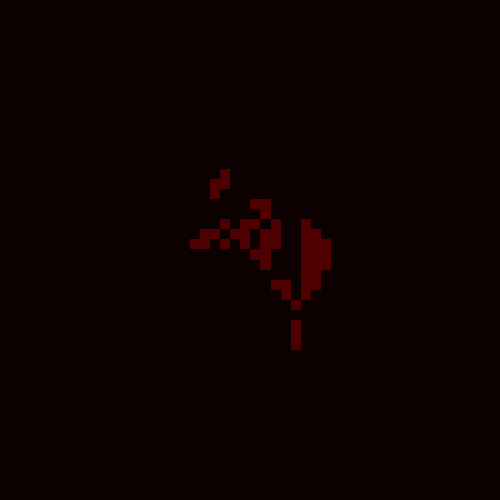
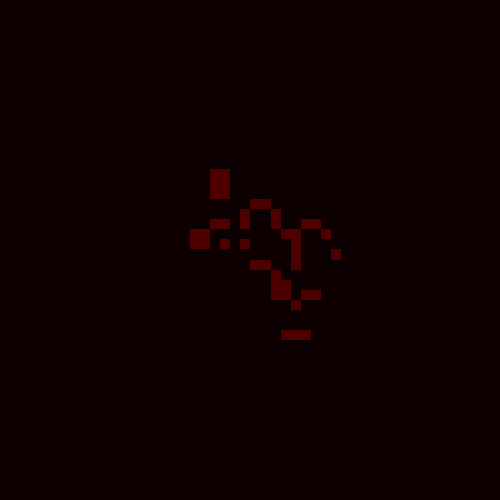
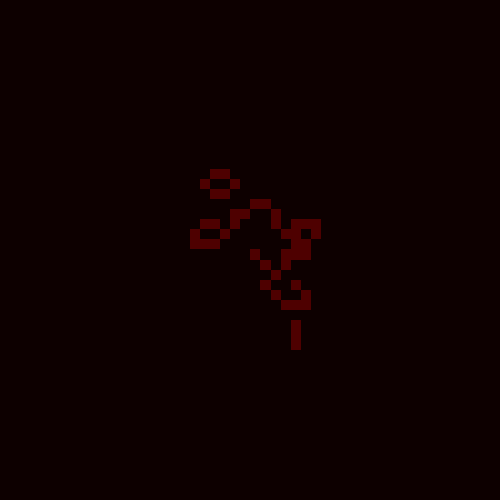
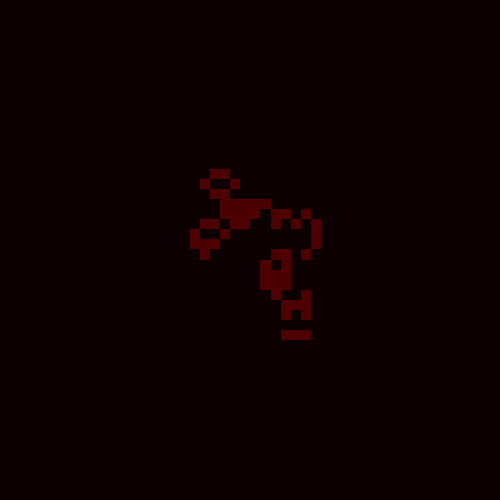
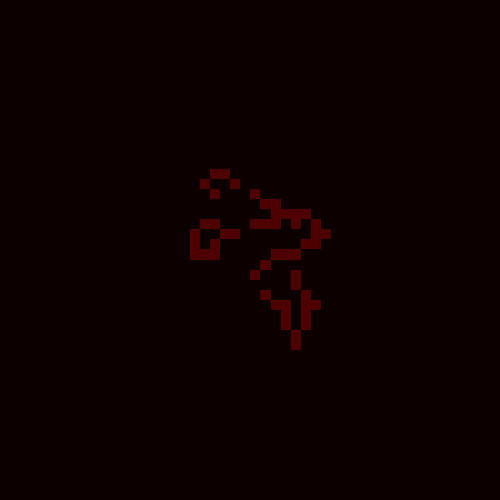
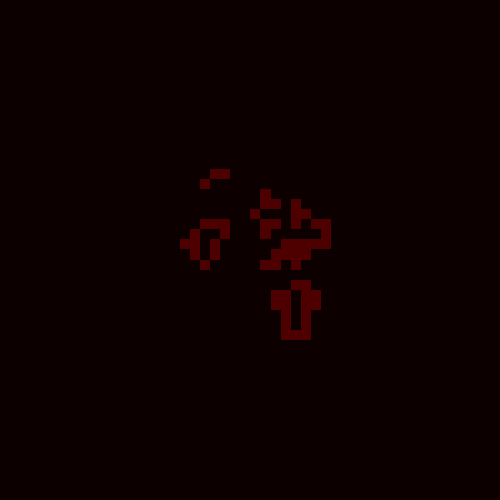
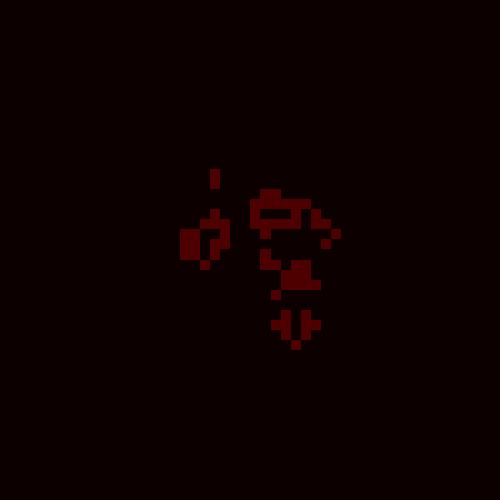
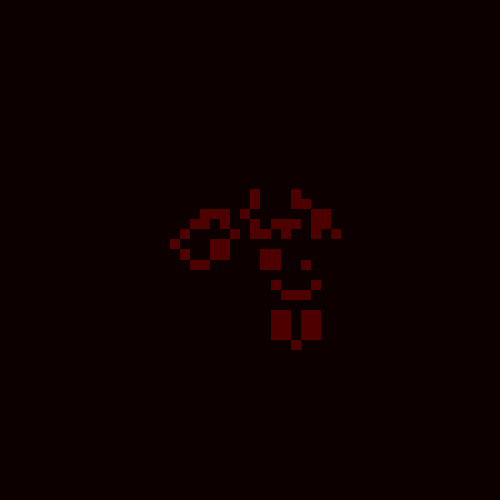
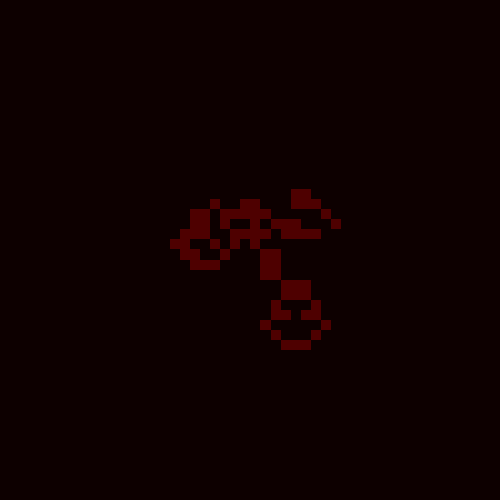
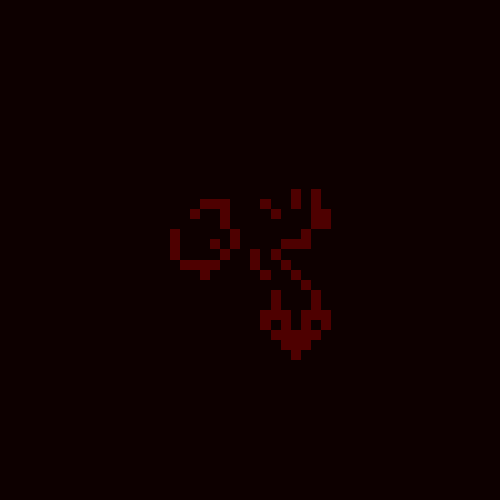
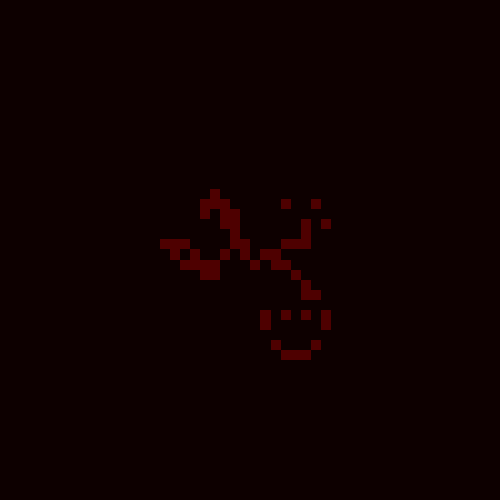
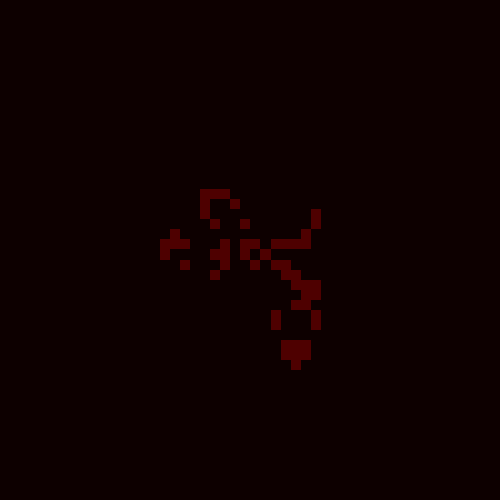
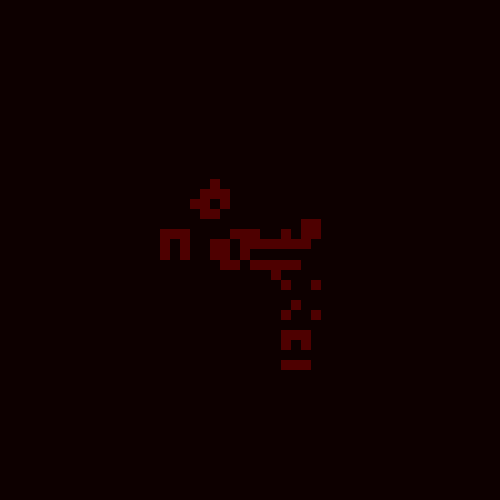
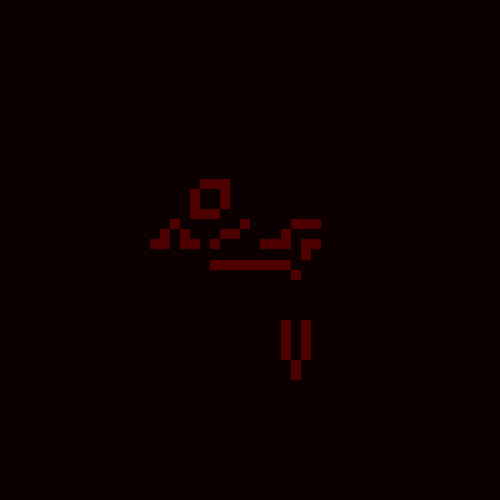
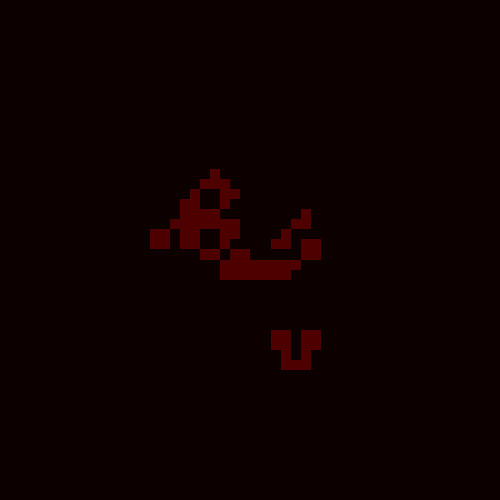
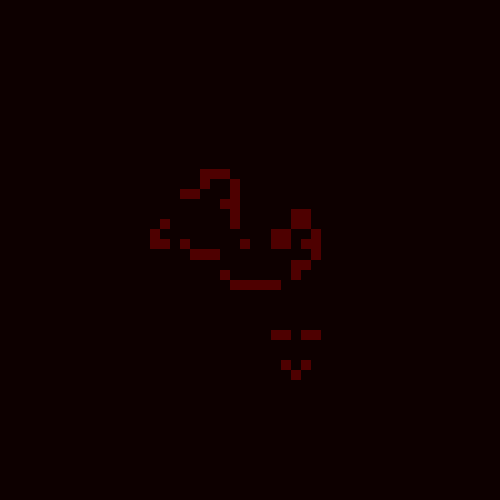
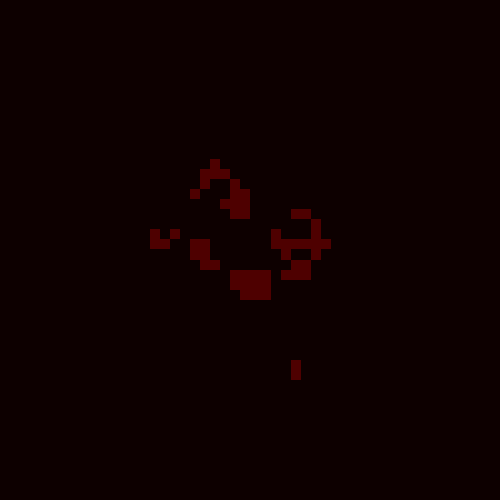
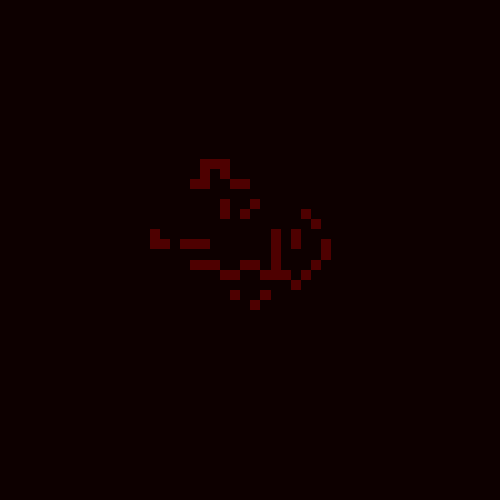
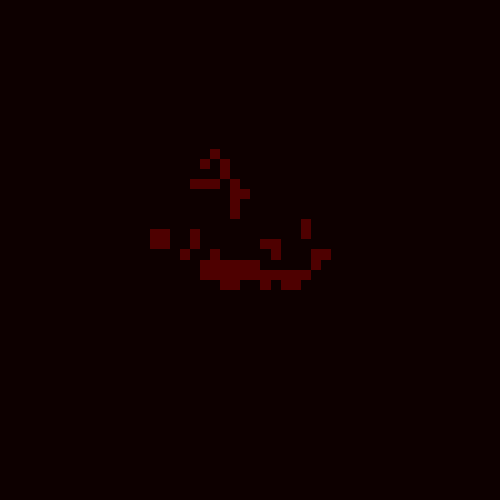
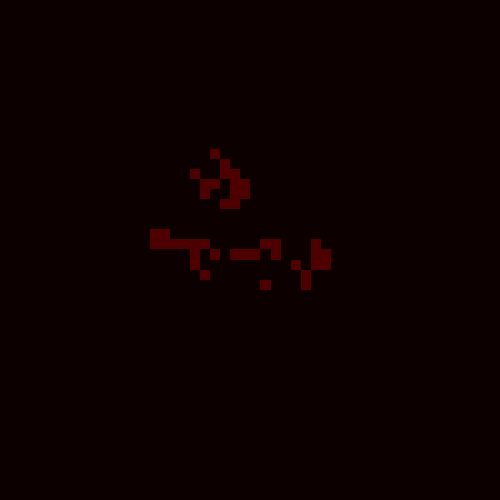
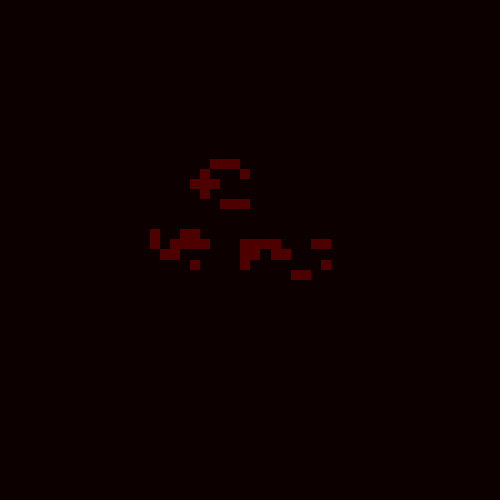
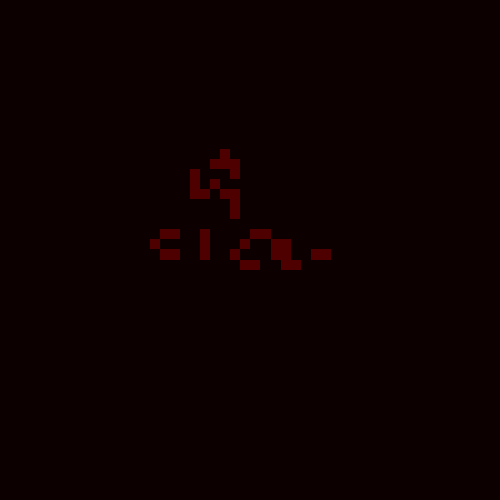
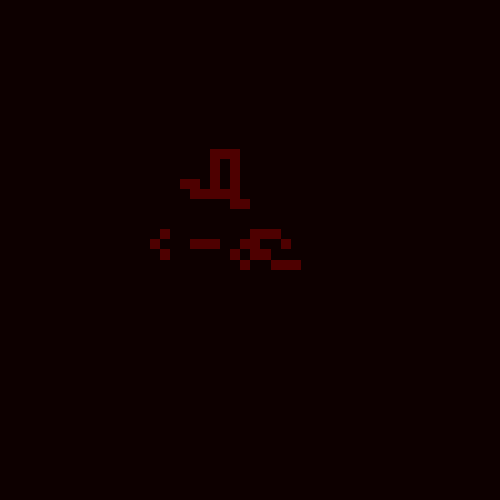
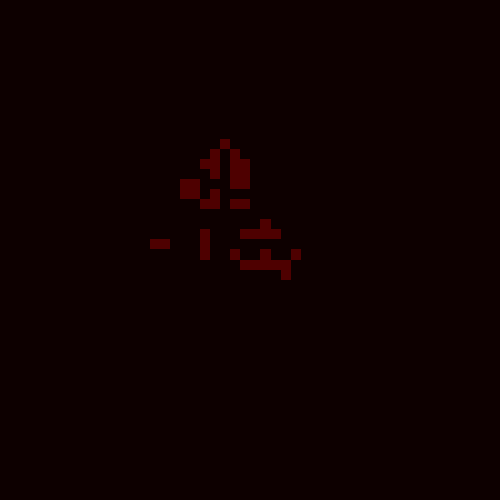
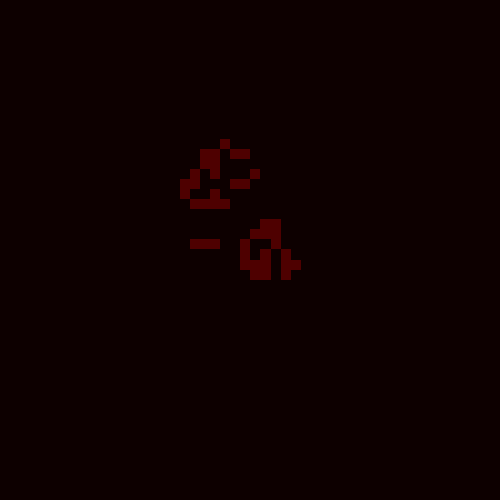
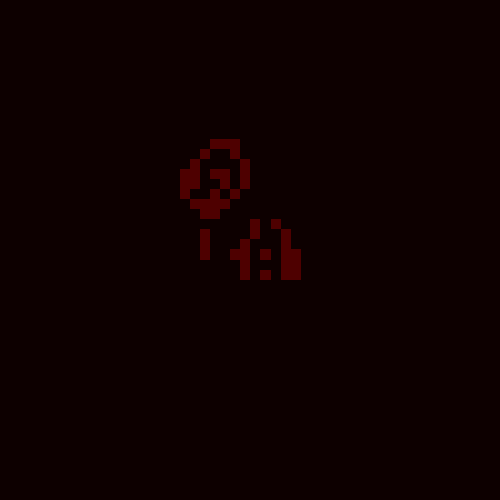
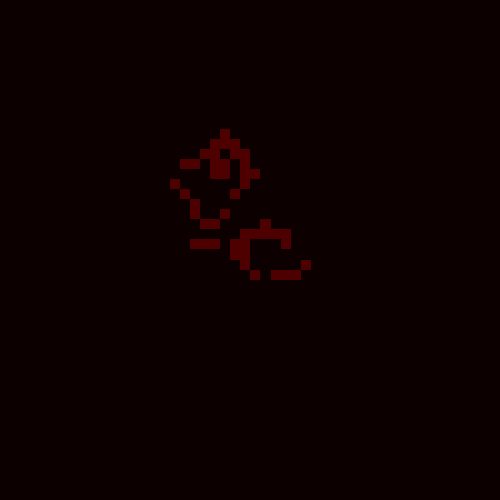
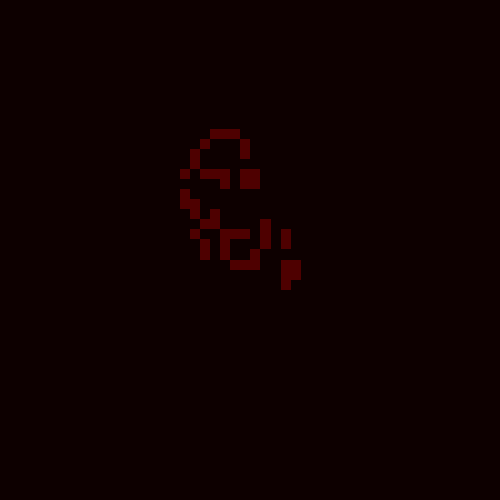
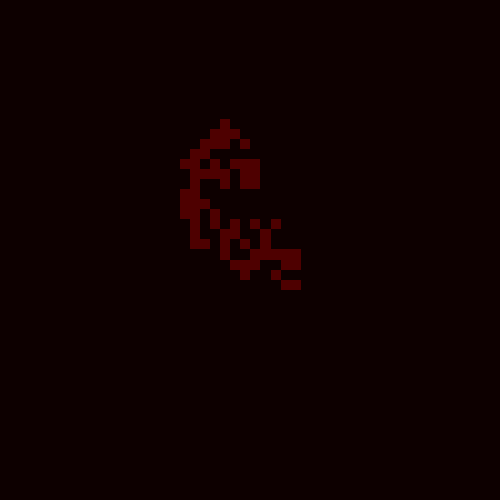
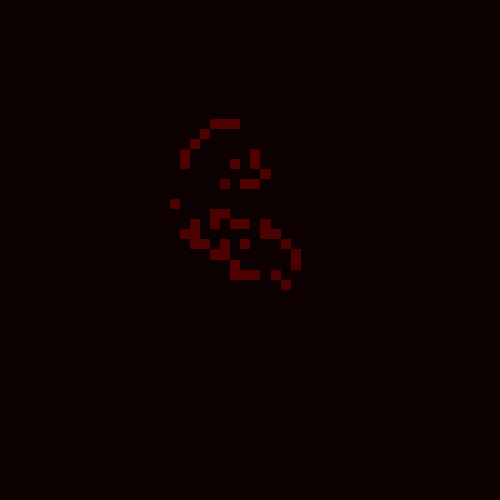
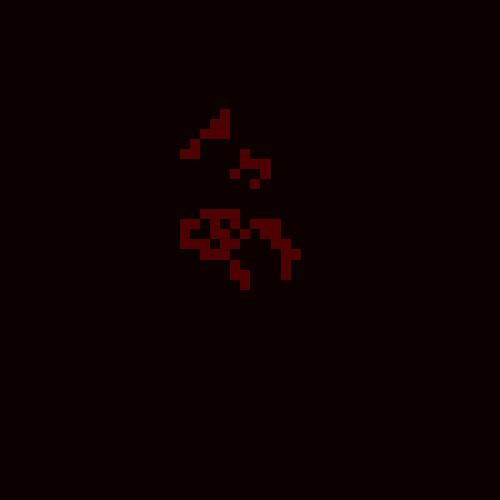
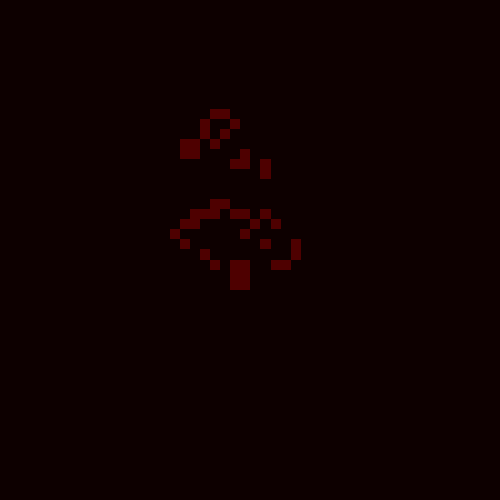
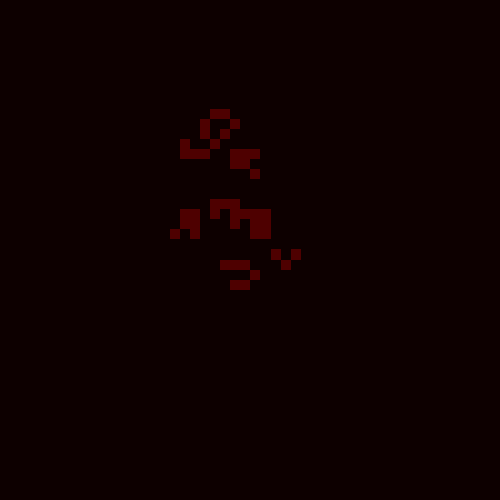
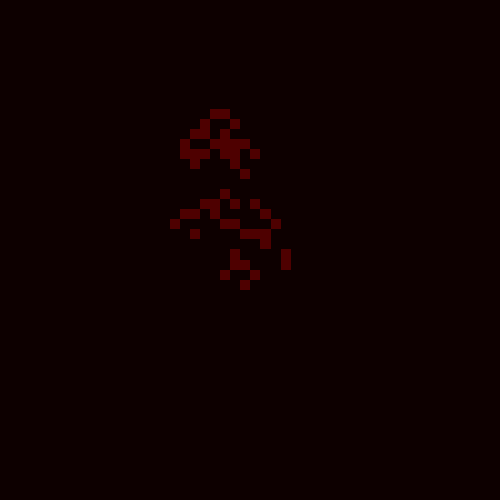
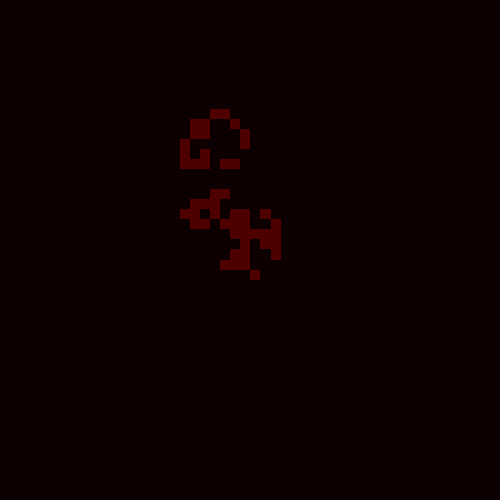
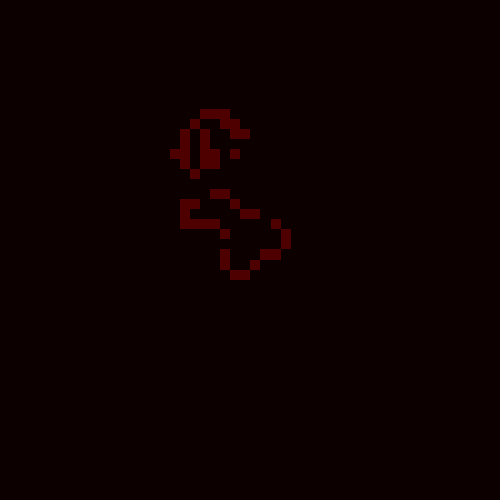
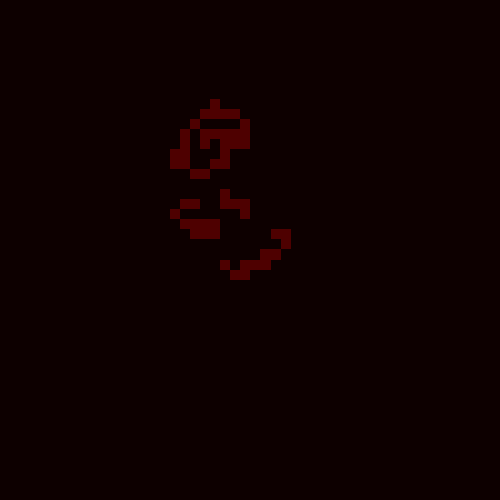
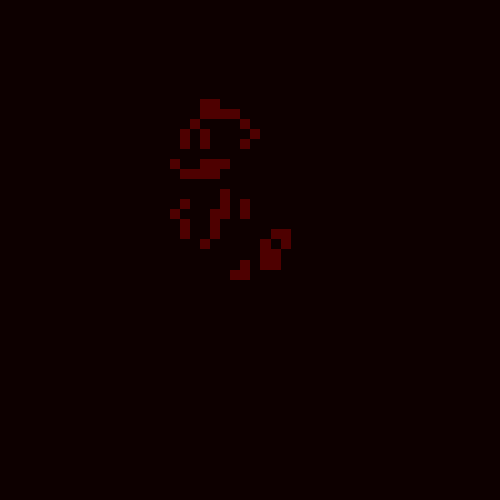
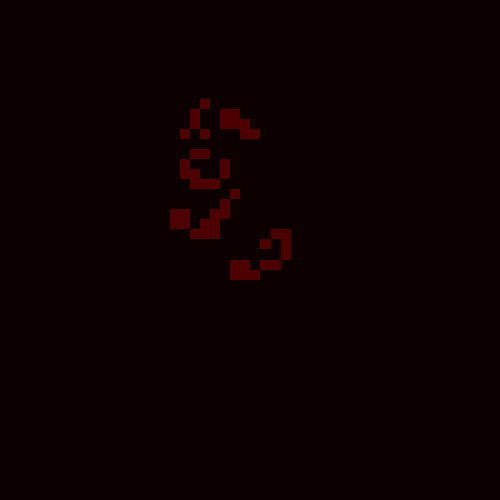
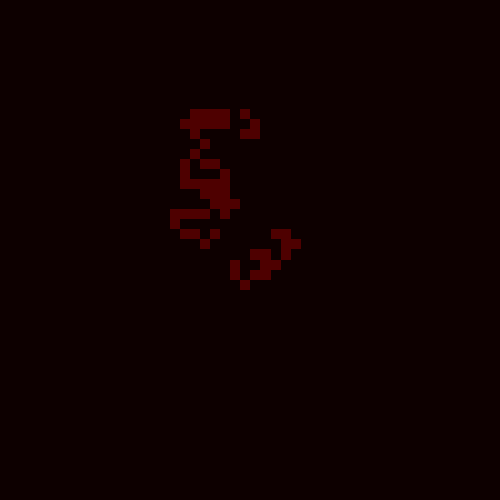
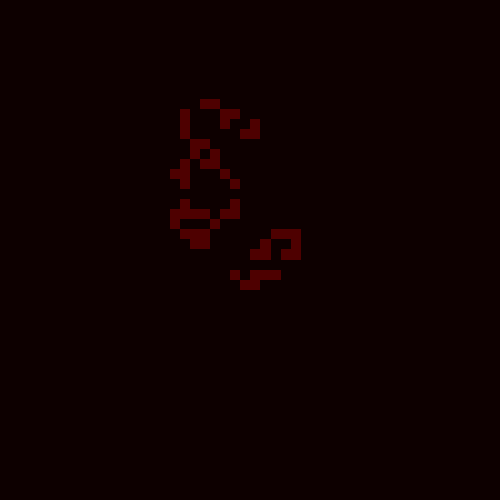
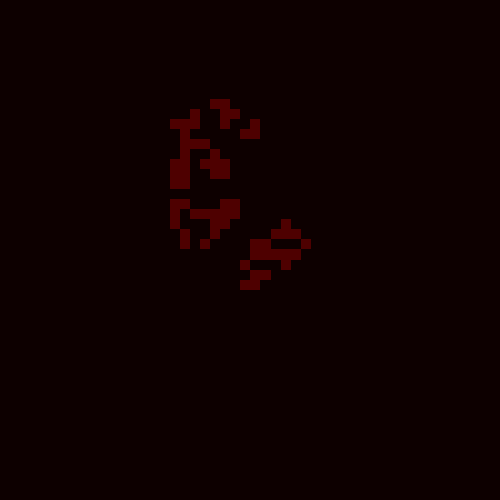
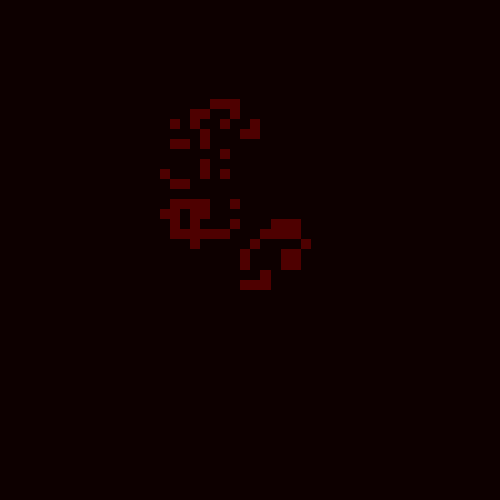
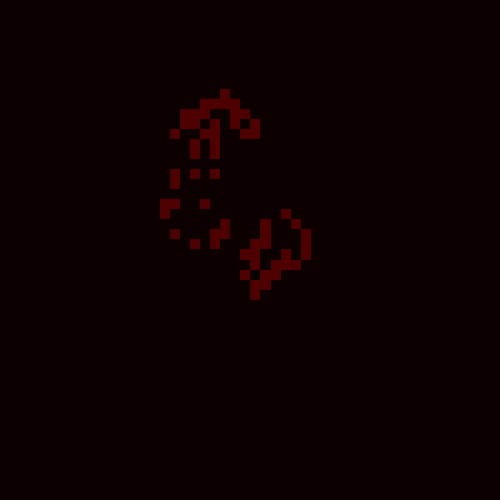
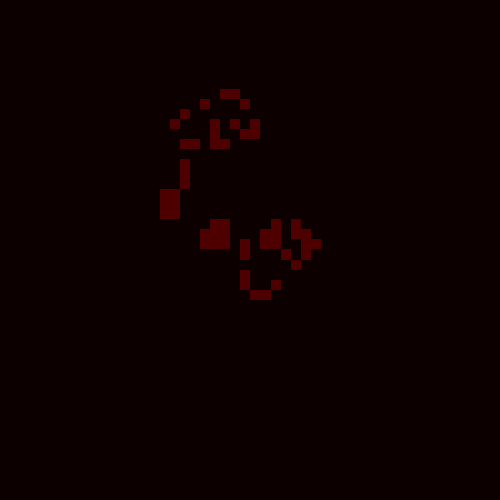
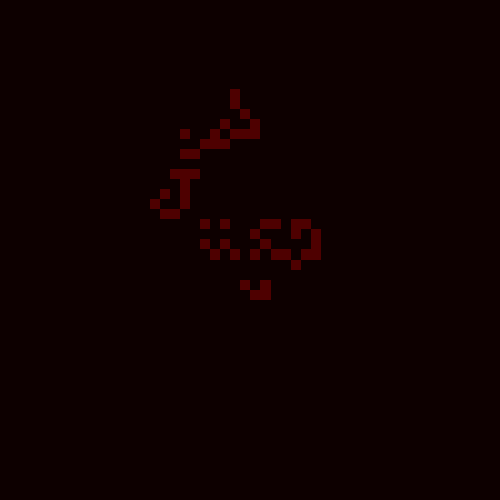
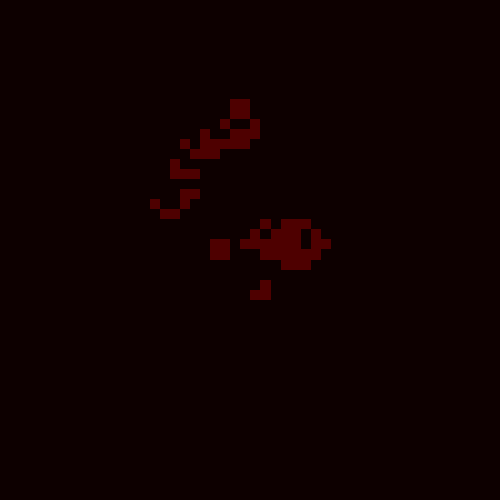
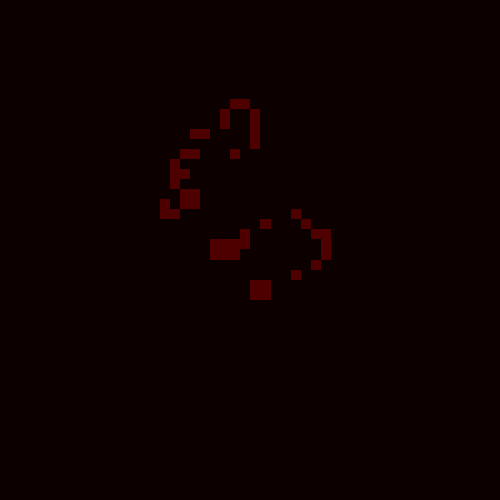
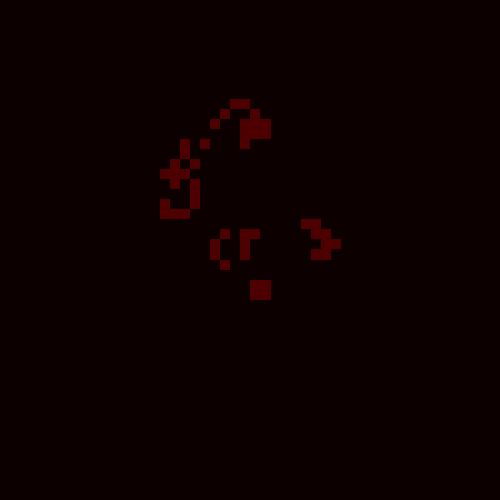
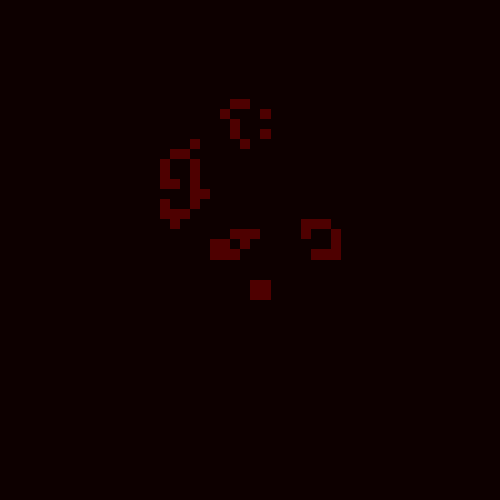
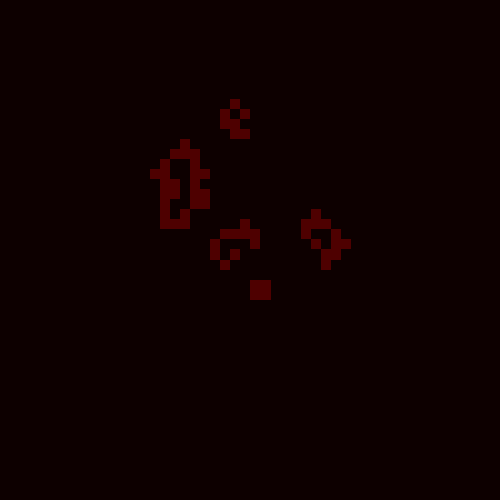
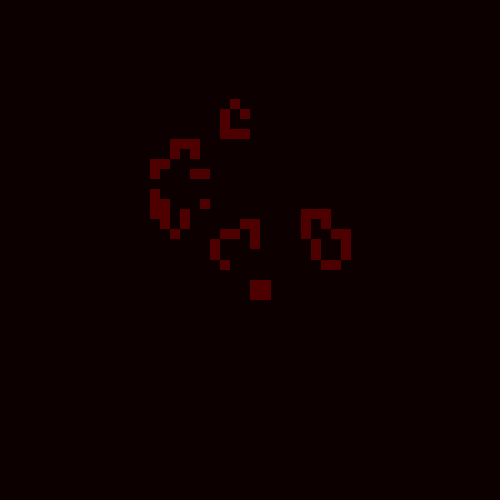
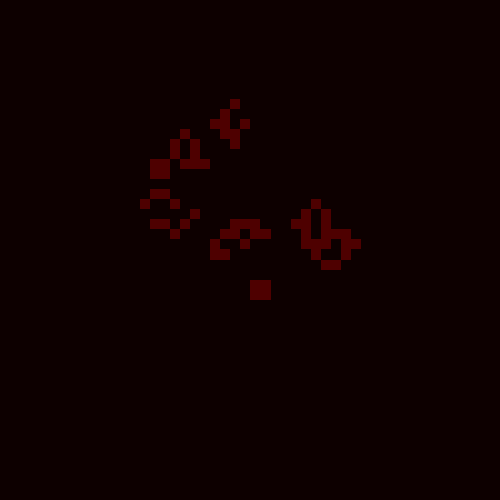
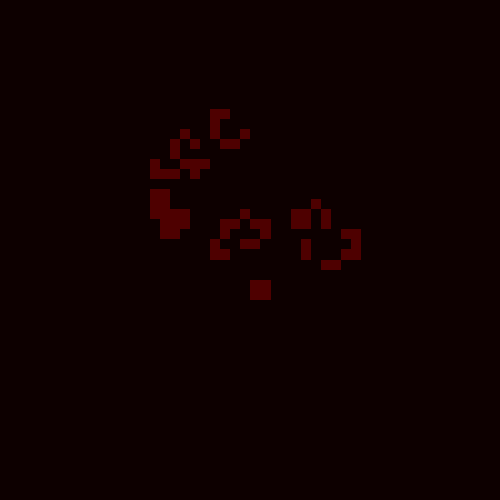
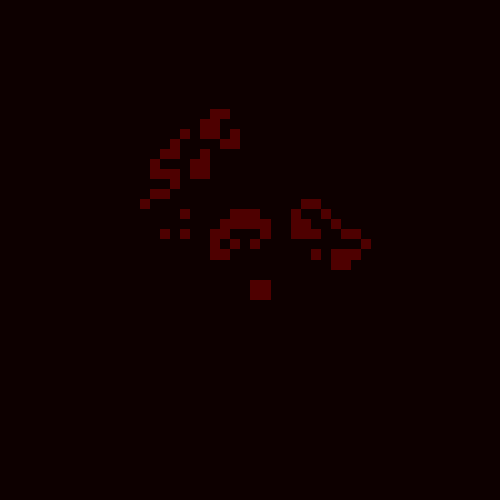
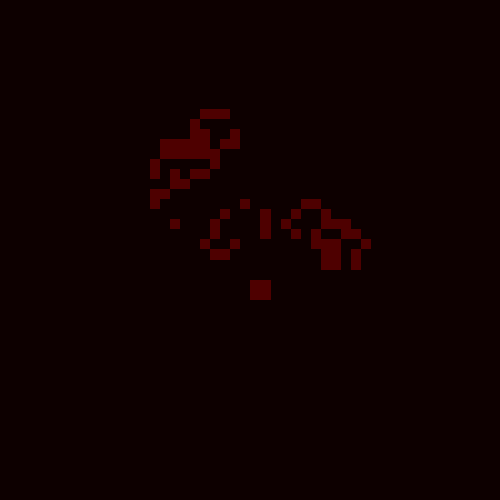
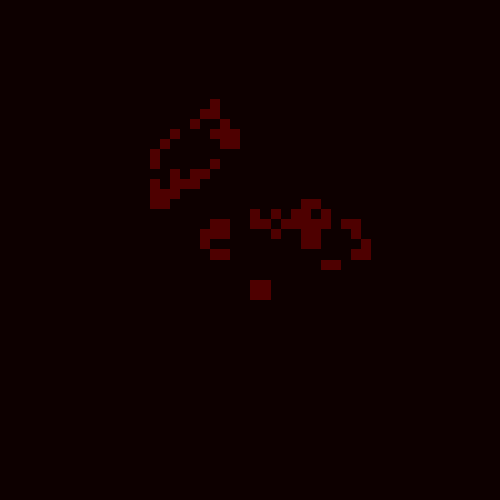
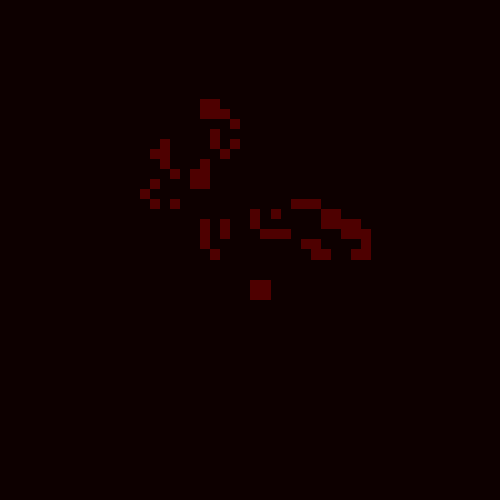
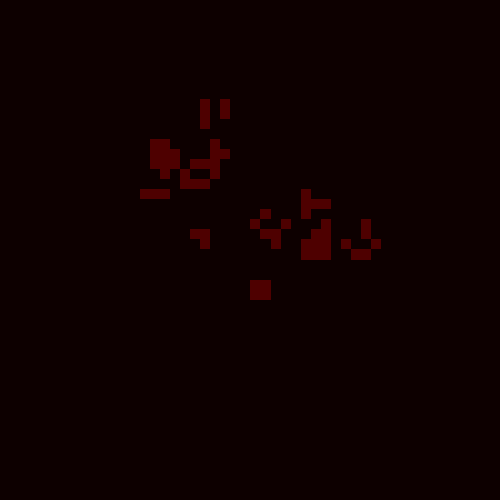
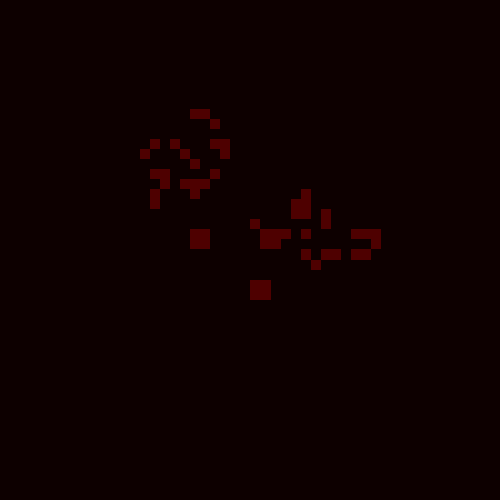
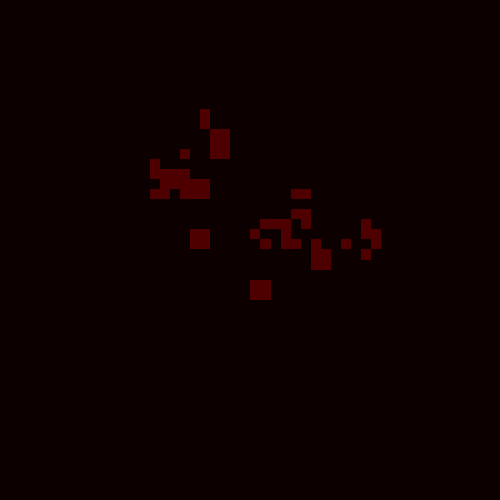
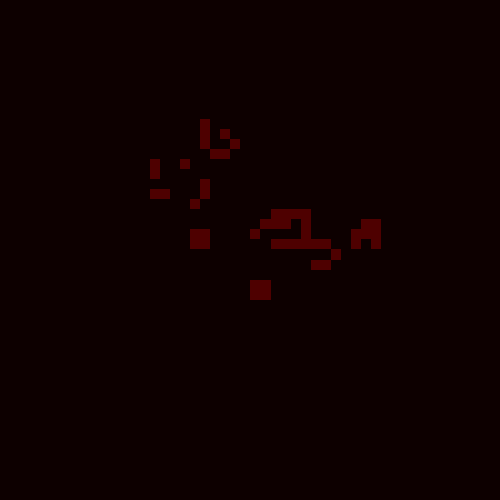
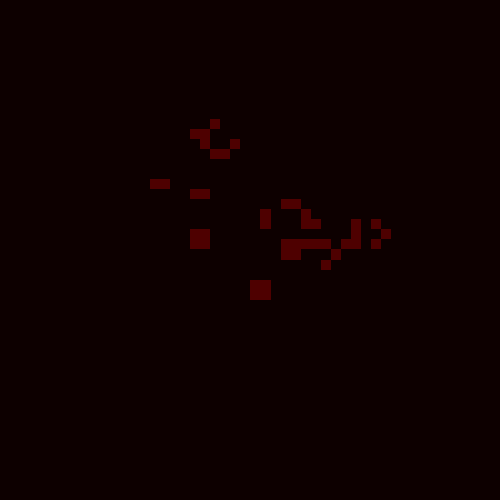
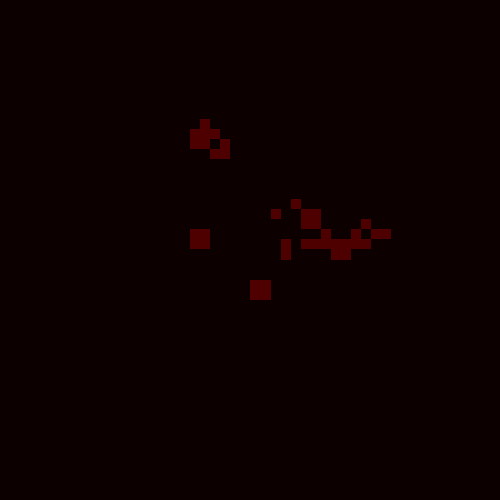

In [6]:
iteration_n = 10
frame_n = 100
xd = 10
yd = 10
sample_n = 50
border = 5

gen_noise = random.choice([0,1], [sample_n, xd*yd])
gen_weights = 2 * random.random((xd*yd, xd*yd)) - 1
des_weights = 2 * random.random((xd*yd, 1)) - 1
    
for k in range(iteration_n):
    
    # Generate Part 1 #########################################################
    
    generated = sig_func(gen_noise, gen_weights)
    
    #print("Generated")
    #print(generated.shape)

    # Evaluate ################################################################

    evaluated = []

    for i in range(sample_n):

        b = add_border(generated[i].reshape([xd, yd]), border)


        for j in range(frame_n-1):

            c = life_step(b.reshape([j+1,xd*border, yd*border])[j,:]).flatten()
            b = np.append(b,c)

        b = b.reshape(frame_n, xd*border, yd*border)

        dw_score = abs((durbin_watson(np.sum(b.reshape([frame_n,
                                                        xd*border*yd*border]),
                                             axis=1).tolist())-2)/2)
        cm_score = np.var(ndimage.center_of_mass(b))
        score = dw_score*np.log(cm_score)
        evaluated = np.append(evaluated,score)
        
    evaluated = evaluated.reshape([sample_n,1])
    
    #print("Evaluated")
    #print(evaluated.shape)

    #Descriminate #############################################################
    
    descriminated = sig_func(generated, des_weights)
    
    #print("Descriminated")
    #print(descriminated.shape)
    
    # Generate Part 2 #########################################################
    
    des_weights += np.dot(generated.T,
                          (evaluated - descriminated) *
                          descriminated *
                          (1 - descriminated))

    result = np.argsort(sig_func(generated, des_weights)).flatten()
    top_n = result[::-1][:int(sample_n/2)]
    bottom_n = result[:int(sample_n/2)]

    gen_weights += np.dot(gen_noise[top_n].T,
                          (generated[top_n] - generated[bottom_n]) *
                          generated[bottom_n] *
                          (1 - generated[bottom_n]))
    
    clear_output(wait=True)
    print("Iteration")
    print(k)

# Get Best and Display ########################################################
    
gen_result = sig_func(gen_noise, gen_weights)
im = np.unique(np.round(gen_result), axis=0)
scores = sig_func(im, des_weights)
top_ind = np.argsort(scores)[::-1][0]
top_score = scores[top_ind]
top_im = im[top_ind].reshape([xd,yd])

clear_output(wait=True)
print(top_im)
print(top_score)   
life_animation(add_border(top_im, 5),
               dpi=15,
               frames=frame_n,
               interval=50,
               mode='once')